# COVID - 19

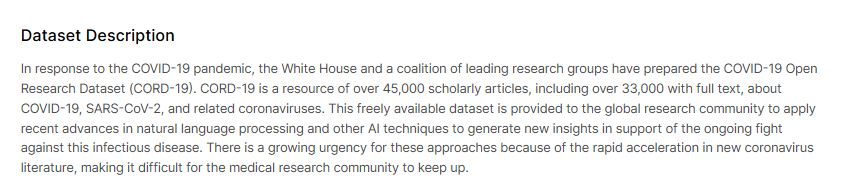

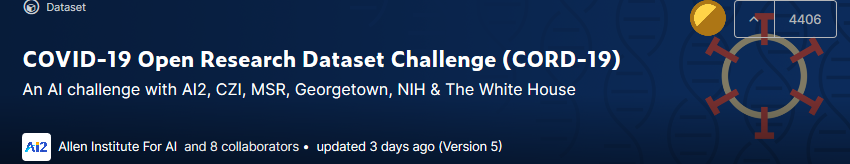

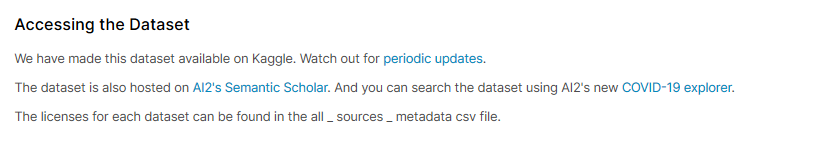

## Importing important library and files

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import re
import json
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import spacy
from spacy.matcher import Matcher
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

In [ ]:
debug = False
articles = {}
stat = { }
paths = ['biorxiv_medrxiv/biorxiv_medrxiv','comm_use_subset/comm_use_subset','custom_license/custom_license','noncomm_use_subset/noncomm_use_subset']
for path in paths:
    lists = list(os.listdir('/kaggle/input/CORD-19-research-challenge/'+path))
    for i in lists:
        articles[i] = os.path.join('/kaggle/input/CORD-19-research-challenge/'+path, i)
df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

In [ ]:
df.head()

In [ ]:
df.shape

**Comment** : There are 45,774 articles, and 17 features. <br>
- sha: Sourvce of article
- source_x: Sourvce of article
- title
- 'pmcid': populated for all PMC paper records 
- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records 
- 'WHO #Covidence': populated for all CZI records and none of the other records 
- 'pubmed_id': populated for some of the records
- 'Microsoft Academic Paper ID': populated for some of the records
- publish_time 
<br>


# Prepare term List

    virus_ref - virus related words in articles is used to filter the dataset.
    symptoms - list of symptoms
    organs - list of human organs
    old - list of terms that are used to define the starting point of an age group
    young - list of terms that are used to define the end of an age group



In [ ]:
virus_ref = ['covid-19', 'coronavirus', 'cov-2', 'sars-cov-2', 'sars-cov', 'hcov', '2019-ncov']
symptoms = ['weight loss','chills','shivering','convulsions','deformity','discharge','dizziness','vertigo','fatigue','malaise','asthenia','hypothermia','jaundice','muscle weakness','pyrexia','sweats','swelling','swollen','painful lymph node','weight gain','arrhythmia','bradycardia','chest pain','claudication','palpitations','tachycardia','dry mouth','epistaxis','halitosis','hearing loss','nasal discharge','otalgia','otorrhea','sore throat','toothache','tinnitus','trismus','abdominal pain','fever','bloating','belching','bleeding','blood in stool','melena','hematochezia', 'constipation','diarrhea','dysphagia','dyspepsia','fecal incontinence','flatulence','heartburn','nausea','odynophagia','proctalgia fugax','pyrosis','steatorrhea','vomiting','alopecia','hirsutism','hypertrichosis','abrasion','anasarca','bleeding into the skin','petechia','purpura','ecchymosis and bruising','blister','edema','itching','laceration','rash','urticaria','abnormal posturing','acalculia','agnosia','alexia','amnesia','anomia','anosognosia','aphasia and apraxia','apraxia','ataxia','cataplexy','confusion','dysarthria','dysdiadochokinesia','dysgraphia','hallucination','headache','akinesia','bradykinesia','akathisia','athetosis','ballismus','blepharospasm','chorea','dystonia','fasciculation','muscle cramps','myoclonus','opsoclonus','tic','tremor','flapping tremor','insomnia','loss of consciousness','syncope','neck stiffness','opisthotonus','paralysis and paresis','paresthesia','prosopagnosia','somnolence','abnormal vaginal bleeding','vaginal bleeding in early pregnancy', 'miscarriage','vaginal bleeding in late pregnancy','amenorrhea','infertility','painful intercourse','pelvic pain','vaginal discharge','amaurosis fugax','amaurosis','blurred vision','double vision','exophthalmos','mydriasis','miosis','nystagmus','amusia','anhedonia','anxiety','apathy','confabulation','depression','delusion','euphoria','homicidal ideation','irritability','mania','paranoid ideation','suicidal ideation','apnea','hypopnea','cough','dyspnea','bradypnea','tachypnea','orthopnea','platypnea','trepopnea','hemoptysis','pleuritic chest pain','sputum production','arthralgia','back pain','sciatica','Urologic','dysuria','hematospermia','hematuria','impotence','polyuria','retrograde ejaculation','strangury','urethral discharge','urinary frequency','urinary incontinence','urinary retention']
organs = ['mouth','teeth','tongue','salivary glands','parotid glands','submandibular glands','sublingual glands','pharynx','esophagus','stomach','small intestine','duodenum','Jejunum','ileum','large intestine','liver','Gallbladder','mesentery','pancreas','anal canal and anus','blood cells','respiratory system','nasal cavity','pharynx','larynx','trachea','bronchi','lungs','diaphragm','Urinary system','kidneys','Ureter','bladder','Urethra','reproductive organs','ovaries','Fallopian tubes','Uterus','vagina','vulva','clitoris','placenta','testes','epididymis','vas deferens','seminal vesicles','prostate','bulbourethral glands','penis','scrotum','endocrine system','pituitary gland','pineal gland','thyroid gland','parathyroid glands','adrenal glands','pancreas','circulatory system','Heart','patent Foramen ovale','arteries','veins','capillaries','lymphatic system','lymphatic vessel','lymph node','bone marrow','thymus','spleen','tonsils','interstitium','nervous system','brain','cerebrum','cerebral hemispheres','diencephalon','the brainstem','midbrain','pons','medulla oblongata','cerebellum','the spinal cord','the ventricular system','choroid plexus','peripheral nervous system','nerves','cranial nerves','spinal nerves','Ganglia','enteric nervous system','sensory organs','eye','cornea','iris','ciliary body','lens','retina','ear','outer ear','earlobe','eardrum','middle ear','ossicles','inner ear','cochlea','vestibule of the ear','semicircular canals','olfactory epithelium','tongue','taste buds','integumentary system','mammary glands','skin','subcutaneous tissue']
old = ['over', 'above', 'higher', 'older', '>', 'over', 'less']
young = ['under', 'below', 'fewer', 'younger', '<', 'under', 'more']

In [ ]:
matchers = {"Term Matcher": lambda term: [{'LOWER': t} for t in term.split(' ')],
    "Terms Matcher": lambda terms: [{"LOWER": {"IN": terms } }],
    "Number Suffix Matcher": lambda periods: [{'LIKE_NUM': True},{"TEXT": {"REGEX": f'({"|".join(periods)})'}}],
    "Number Interval Matcher": lambda periods: [{'POS': 'NUM',},{'TEXT': {'REGEX': f'({"|".join(periods)})'}, 'OP': '?'},{'DEP': 'quantmod', 'OP': '?'},{'DEP': 'punct', 'OP': '?'},{'DEP': 'prep', 'OP': '?'},{'POS': 'NUM'},{'TEXT': {'REGEX': f'({"|".join(periods)})'}},],
    "Group Matcher": [{"TEXT": {"IN": old+young }}]}

# Defining important function for further smothening of execution****

* plot_dict - plot a dictionary
* dict_counter - set the value of a key in the dictionary
* day_value - determine value of days
* report_interval - populates dictionary with values for an interval
* virus_match - to checks if any virus term is present in the text or not


In [ ]:
def plot_dict(stat,t = 10,sort_values = False,barh = False,width = 20,height = 4,title = ''):
    filtered = dict(stat)
    delete = []
    for i in filtered:
        if filtered[i] < t:
            delete.append(i)
    for i in delete:
        del filtered[i]
    if sort_values == False:
        lists = sorted(filtered.items())
    else:
   #     if sort_values == True:
        lists = sorted(filtered.items())#, key = lambda item : item[1]
       # else:
         #   lists = sorted(filtered.items(), key = sort_values)
    fig = figure(num=None, figsize=(width, height))    
    if title != '':
        fig.suptitle(title, fontsize=20)        
    x, y = zip(*lists) 
    if barh == True:
        plt.barh(x, y)
    else:
        plt.bar(x, y)
    plt.show()
def merge_keys(mergers, obj):
    result = dict(obj)
    for key, arr in mergers:
        if key not in result:
            result[key] = 0
        for merger in arr:
            if merger in result:
                result[key] = result[key] + result[merger]
                del result[merger]
    return result
def dict_counter(res, arg):
    try:
        key = str(arg)
        res.setdefault(key, 0)
        res[key] = res[key] + 1
    except:
        pass
def numval(val):
    try:
        return int(float(str(val))) 
    except:
        return None
def day_value(val, rep = None):
    if rep != None:
        val = numval(val.text)
        if val != None and 'week' in rep.text:
            val = val * 7
        return val
    else:
        return None
def report_interval(res, min_val, max_val):       
    if min_val != None and max_val != None:
        for key in range(min_val, max_val):
            res.setdefault(key, 0)
            res[key] = res[key] + 1    
def virus_match(text):
    return len(re.findall(rf'({"|".join(virus_ref)})', text, flags=re.IGNORECASE)) > 0

# Importing the JSON files

In [ ]:
literature = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sha = str(row['sha'])
    if sha != 'nan':
        sha = sha + '.json';
        try:
            found = False
            with open(articles[sha]) as f:
                data = json.load(f)
                for key in ['abstract', 'body_text']:
                    if found == False and key in data:
                        for content in data[key]:
                            text = content['text']
                            if virus_match(text) == True:                                
                                literature.append({'file': articles[sha], 'body': text})                                
        except KeyError:
            pass

# Prepared dataset for COVID-19

In [ ]:
len(literature)

## Defining other important functions

In [ ]:
def execute_matches(match_arr,root,sentence,file,index = 0,execution = []):
    key, result = match_arr[0]
    rest = match_arr[1:]
    ne = execution + [(key, result, index)]
    if key in root:
        r = root[key]
        if callable(r):
            r( (result, ne, sentence, file) )            
        else:
            if 'execute' in r:
                rule['execute']( (result,ne,sentence,file) )
            if len(rest) > 0:
                execute_matches(rest,r,sentence,file,index+1,ne)
    
    if len(rest) > 0:               
        execute_matches(rest, root, sentence, file, index + 1, execution)    
def merge_dict_values(original,rules,drop = []):
    a = {}
    b = {}
    for key, values in rules:
        for val in values:
            b[val] = key
    for key in original.keys():
        new = key if key not in b else b[key]        
        if key not in drop and new not in drop:
            val = original[key]            
            a[new] = val if new not in a else a[new] + val
    return a   
def merge_matches(matches, doc):
    a = []
    b = (None, None, None)
    for ids, start, end in matches:   
        if ids != b[0] or b[2] < start:
            if b[0] != None:
                a.append(b)
            b = (ids, start, end)
        elif b[2] < end:
            b = (ids, b[1], end)
    a.append(b)
    return a;

def match_parser(matcher, doc, rule, file):
    match = matcher(doc)
    if len(match)>0:
        to_process = []
        for match_id, start, end in merge_matches(match, doc):
            string_id = nlp.vocab.strings[match_id]
            span = doc[start:end]
            to_process.append((string_id, span))
        execute_matches(to_process, rule['root'], doc, file)

def parse_body(matcher, text, rule, file = None, sentence_level = False):
    text = text.lower()
    doc = nlp(text)
    if sentence_level == True:    
        for sent in doc.sents:
            sent_doc = nlp(sent.text)
            match_parser(matcher, sent_doc, rule, file)
    else:
        match_parser(matcher, doc, rule, file)

def execute_ruleset(term, rule, sentence_level = False, literature = literature):
    matcher = Matcher(nlp.vocab)
    for name, m in rule["Matchers"]:
        matcher.add(name, None, m)
    for article in tqdm(literature):
        text_list = re.compile("\. ").split(article['body'])
        file = article['file']
        for text in text_list:
            if callable(term):
                allow = term(text)
            else:
                allow = term == None or term in text
            if allow == True:
                parse_body(matcher, text, rule, file, sentence_level) 

# Virus Symptoms
Searching for word representing symptoms in all articles that have a coronaviru,that matches at least one term in symptoms.*

In [ ]:
stat['symptoms'] = {}
def match(text):
    if virus_match(text) == True:
        return len(re.findall(rf'\ ({"|".join(symptoms)})\ ', text)) > 0
    else:
        return False
def symptom(res):
    ref, agregate, sentence, file = res
    dict_counter(stat['symptoms'], ref.text)
rule = {"Matchers": [("Symptoms Reference", matchers['Terms Matcher'](symptoms)),],"root": {"Symptoms Reference": symptom}}
def symptom_match(text):
    return len(re.findall(r'symptom', text)) > 0
execute_ruleset(symptom_match, rule)
plot_dict(stat['symptoms'], 50, True, title = "Manifested Symptoms")

In [ ]:
stat

# Virus Transmission
Searching for word representing transmission in all articles that have a coronaviru,that matches at least one term in transmission.

In [ ]:
stat['transmission'] = {}
def report_term(x):
    arr = x[1]
    m1, v1, i1 = arr[0]
    m2, v2, i2 = arr[1]
    m3, v3, i3 = arr[2]
    if m1 == 'Term Matcher' and m2 == 'Form Matcher':
        dict_counter(stat['transmission'], re.sub(r'[ ]?(-|the| a )[ ]?','', v3.text))
term_match = ['transmit','transmitted', 'spread', 'spreaded']
rule = {"Matchers": [("Term Matcher", [{"LOWER": "now", "OP": "!"}] + matchers["Terms Matcher"](term_match)),
        ("Form Matcher", matchers["Terms Matcher"](['through', 'by', 'via'])),
        ("Noun Matcher", [{"POS": "VERB", "OP": "?"},{"POS": "DET", "OP": "?"},{"POS": "ADJ", "OP": "?"},{"POS": "PUNCT", "OP": "?"},{"POS": "ADJ", "OP": "?"},{"POS": "NOUN", "OP": "+"},])],
    "root": { "Term Matcher": {"Form Matcher": {"Noun Matcher": report_term}}}}
def transmission_match(text):
    return len(re.findall(rf'({"|".join(term_match)})', text)) >0

execute_ruleset(transmission_match, rule, False)
new_dict = merge_dict_values(stat['transmission'], [('contact', ['direct contact', 'close contact', 'indirect contact', 'person contact']),
    ('respiratory droplets/route', ['droplets','air', 'airborne route', 'aerosols', 'airborne transmission', 'respiratory route','respiratory droplets', 'droplet', 'respiratory secretions']),
    ('surfaces/fomites', ['fomites', 'surfaces', 'environmental surfaces', 'environment']),
    ('human transmission', ['human','humans','patient', 'patients','person', 'people']),
    ('fecal-oral route', ['fecaloral route', 'faecaloral route'])], ['%', 'virus', 'viruses'])
plot_dict(new_dict, 30, True, barh = True, height = 20, title = 'Transmission Routes')

In [ ]:
stat.keys()

# Organs affected by Corona
Searching for word representing organs in human body in all articles that can be affected by coronaviru that matches at least one term in transmission.

In [ ]:
stat['organs'] = {}
def match(text):
    if virus_match(text) == True:
        return len(re.findall(rf'\ ({"|".join(organs)})\ ', text)) > 0
    else:
        return False
def organ_ref(res):
    ref, agregate, sentence, file = res
    dict_counter(stat['organs'], ref.text)
        
rule = {"Matchers": [("Organ Reference", matchers['Terms Matcher'](organs)),],
    "root": {"Organ Reference": organ_ref}}
def organ_match(text):
    res = re.findall(rf'\ ({"|".join(organs)})\ ', text, flags=re.IGNORECASE)    
    return len(res) >0

execute_ruleset(organ_match, rule)
plot_dict(stat['organs'], 500, True, title = 'Affected Organs')